## Analyse de données
***Ce script a pour but d'analyser les données des donateurs réguliers (en terme de donations) ainsi que d'analyser le churn de ces donateurs et ce qui différencie les deux catégories.***  
On se base sur le dataset propre traité par le premier script de feature engineering.

#### Importation des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline
pd.options.display.max_columns = None

#### Lecture des données
On lit les données enregistrées dans la répertoire 'PATH_DATA', qui ont été préalablement traitées par le script __Feat_Eng_1__.

In [5]:
# Chemin vers les données, par défaut '../data'
PATH_DATA = "../data"

In [6]:
# Lecture des données
def read_regular_donator(data_filepath):
    """
    Lit les données des donateurs réguliers enregristrés via le premier script de feature engineering
    """
    donators_regular = pd.read_csv(os.path.join(data_filepath,'dons_reguliers_cleaned.csv'))
    
    # on ne garde que les prélèvements automatiques pour analyser les donations régulières
    donators_regular = donators_regular.loc[donators_regular.CAM_CODE == 'PA']
    return donators_regular

dons_reg = read_regular_donator(PATH_DATA)
dons_reg.head()

,VENTILATION_ID,DATE_DE_RECEPTION,ID_CONTACT,MONTANT_MOUVEMENT,CAM_CODE,OPERATION,SEGMENT,MOUVEMENT_ID,OFT_CODE,MODE_DE_PAIEMENT,MONTANT_VENTILATION
0,2415602.0,2014-01-10,713843,10.0,PA,PA,PA,1116673.0,DON,PRE,10.0
1,2415603.0,2014-01-10,818435,7.0,PA,PA,PA,1116674.0,DON,PRE,7.0
2,2415604.0,2014-01-10,811465,10.0,PA,PA,PA,1116675.0,DON,PRE,10.0
3,2415605.0,2014-01-10,818439,10.0,PA,PA,PA,1116676.0,DON,PRE,10.0
4,2415606.0,2014-01-10,818443,0.0,PA,PA,PA,1116677.0,DON,PRE,0.0


### Analyse des donateurs
On calcule pour ce segment le nombre de donateurs, le nombre de dons moyens, le montant moyen par dons, le revenu généré ainsi que la transaction la plus commune.

In [7]:
# Etude statistique
nb_reg = dons_reg.ID_CONTACT.nunique()
nb_don_moyen_donateur_reg = dons_reg.ID_CONTACT.value_counts().values.mean()
mean_montant_reg = dons_reg[['MONTANT_MOUVEMENT', 'MOUVEMENT_ID']].groupby('MOUVEMENT_ID').agg('sum').MONTANT_MOUVEMENT.mean()
max_transac_reg = dons_reg.MONTANT_VENTILATION.value_counts().index[0]
nb_max_transac_reg = dons_reg.MONTANT_VENTILATION.value_counts().values[0]

print("Il y a {} donateurs réguliers entre 2014 et 2018.".format(nb_reg))
print("Les donateurs réguliers font en moyenne {} dons".format(round(nb_don_moyen_donateur_reg, 1)))
print("Les donateurs réguliers donnent en moyenne {}€ par dons".format(round(mean_montant_reg, 2)))
print("Cela génère donc un revenu moyen de {}€ par donateur régulier.".format(round(nb_don_moyen_donateur_reg * mean_montant_reg, 2)))
print("La transaction la plus commune correspond à un virement de {}€ ({} transactions).".format(max_transac_reg, nb_max_transac_reg))

Il y a 21641 donateurs réguliers entre 2014 et 2018.
Les donateurs réguliers font en moyenne 24.1 dons
Les donateurs réguliers donnent en moyenne 11.18€ par dons
Cela génère donc un revenu moyen de 269.37€ par donateur régulier.
La transaction la plus commune correspond à un virement de 10.0€ (174721 transactions).


[Text(0, 0.5, 'nombre de donateurs'), Text(0.5, 0, 'temps')]

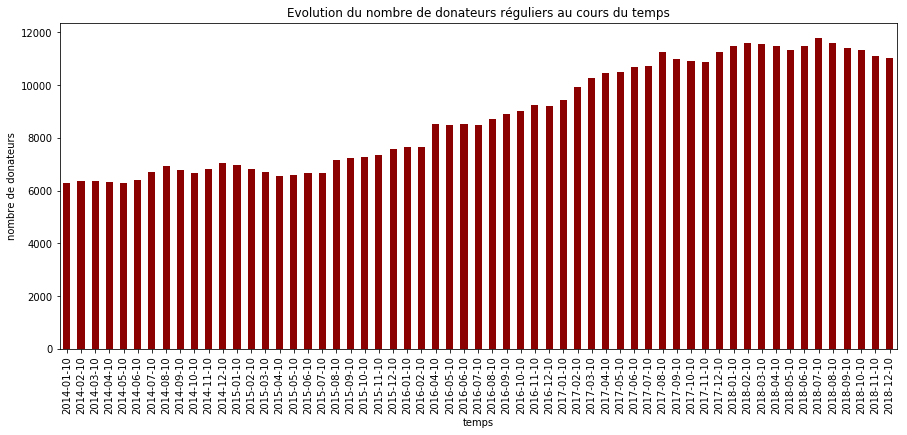

In [8]:
# Evolution du nombre de donateurs réguliers au cours du temps
nb_transac_reg = dons_reg[dons_reg.CAM_CODE == 'PA'][['DATE_DE_RECEPTION', 'ID_CONTACT']].groupby('DATE_DE_RECEPTION').agg('nunique')
ax = nb_transac_reg.ID_CONTACT.plot(kind='bar', figsize=(15, 6), 
                              title="Evolution du nombre de donateurs réguliers au cours du temps", 
                              color="darkred")
ax.set(xlabel="temps", ylabel="nombre de donateurs")

### Analyse du churn
On définit le churn pour un mois N comme suit : c'est le nombre de personnes qui ont donné au mois N mais qui ne donne plus au mois N+1 divisé par le nombre de donateurs réguliers au mois N.

In [9]:
# Calcul du nombre de clients qui ont churnés par mois
contact_date = dons_reg[['ID_CONTACT', 'DATE_DE_RECEPTION']].groupby('ID_CONTACT').agg('max')
contact_date['NB_CHURN'] = 1
date_churn = contact_date.groupby('DATE_DE_RECEPTION').agg('count')
date_churn = date_churn.loc[date_churn.index != '2018-12-10']

# Calcul du nombre de clients par mois
date_nb = dons_reg[['DATE_DE_RECEPTION', 'ID_CONTACT']].groupby('DATE_DE_RECEPTION').agg('count')
date_nb = date_nb.rename(columns={'ID_CONTACT' : 'NB_DONATEURS'})

# Calcul du taux de churn par mois
date_nb_churn = date_nb.merge(date_churn, how='inner', left_on='DATE_DE_RECEPTION', right_on='DATE_DE_RECEPTION')
date_nb_churn['TAUX_CHURN'] = date_nb_churn.NB_CHURN / date_nb_churn.NB_DONATEURS
date_nb_churn.head()

,NB_DONATEURS,NB_CHURN,TAUX_CHURN
DATE_DE_RECEPTION,,,
2014-01-10,6298,99,0.015719
2014-02-10,6358,60,0.009437
2014-03-10,6376,87,0.013645
2014-04-10,6324,59,0.009330
2014-05-10,6282,56,0.008914


[Text(0, 0.5, 'taux de churn'), Text(0.5, 0, 'temps')]

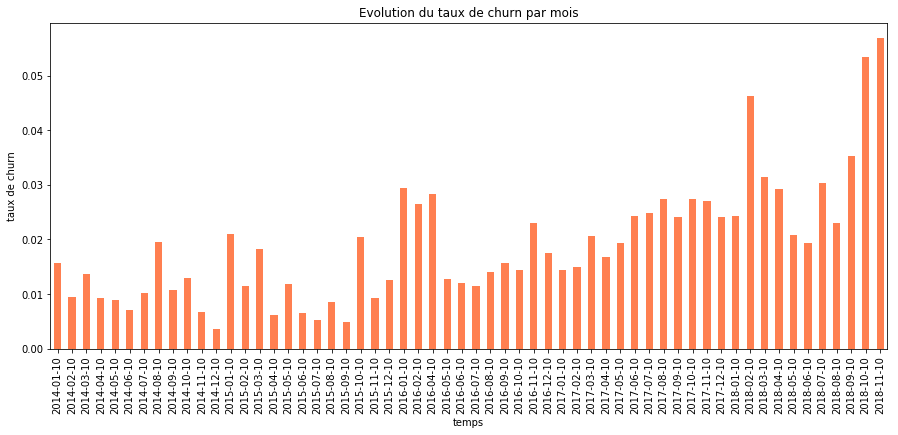

In [10]:
# évolution du taux de churn par mois
ax = date_nb_churn.TAUX_CHURN.plot(kind='bar', figsize=(15, 6),
                                   title="Evolution du taux de churn par mois",
                                   color="coral")
ax.set(xlabel="temps", ylabel="taux de churn")

### Analyse de chaque type de clients
On analyse séparemment les caractéristiques de chaque type de clients : ceux qui ont churnés, ceux qui sont restés fidèles.
##### Séparation des clients

In [11]:
# split des contacts selon ceux qui churnent ou non
contact_churn = contact_date.loc[contact_date.DATE_DE_RECEPTION != '2018-12-10'].index
contact_no_churn = contact_date.loc[contact_date.DATE_DE_RECEPTION == '2018-12-10'].index

# split du dataset de dons selon les donateurs qui churnent ou non
dons_churn = dons_reg.loc[dons_reg.ID_CONTACT.isin(contact_churn)]
dons_no_churn = dons_reg.loc[dons_reg.ID_CONTACT.isin(contact_no_churn)]

In [12]:
# Analyse des mails envoyés
mail = pd.read_excel(os.path.join(PATH_DATA, 'stat_mailjet.xlsx'))
mail = mail.drop(['id'], axis=1)

# création de ratios
mail['ratio_ouvert'] = np.where(mail['sent'] != 0, mail['open'] / mail['sent'], 0)
mail['ratio_click'] = np.where(mail['sent'] != 0, mail['click'] / mail['sent'], 0)
mail = mail[['email', 'sent', 'ratio_ouvert', 'ratio_click']]
mail.head()

,email,sent,ratio_ouvert,ratio_click
0,d345b2515a0b71245d55f02b30b4195c01248abc89d07a...,87,0.965517,0.057471
1,0ba610308e1f8b21c073666dff3552445671604e4828e3...,32,0.093750,0.000000
2,b4f0173422313478eb256fb09b78dc6c305c92540b59dd...,9,0.333333,0.000000
3,35ae1e1ced2315c89951b11b3455b89b054b34d0b28445...,2,1.000000,0.000000
4,4effed70c78fa5cf91ac436da9e2c209f52ad9be4f869a...,0,0.000000,0.000000


In [13]:
# Lecture des contacts
dons_contacts = pd.read_csv(os.path.join(PATH_DATA,'dons_contact_cleaned.csv'))
dons_contacts = dons_contacts[['EMAIL_ADRESSE', 'ID_CONTACT']]
dons_contacts.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (47,58,59,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,EMAIL_ADRESSE,ID_CONTACT
0,f3ab0b82bafdb3c34a5b7e18d0e8efd7a58f36a6bfa2f3...,713843
1,efdb54591cc020b3a60b31a6e28eba5249b8926c8e824b...,818435
2,61746a83c98ad9b4801316f6f4bf2167a17bffc15becc2...,811465
3,1bee142df5e8361664a4c69c984eb309f673f0822622f6...,818439
4,47305162d4482f2c167cab9fcb9f242bc31d8f7452e94d...,818443


In [14]:
# jointures mail / contacts
mail_cont = mail.merge(dons_contacts, how='inner', left_on='email', right_on='EMAIL_ADRESSE')
mail_cont = mail_cont.drop(['EMAIL_ADRESSE'], axis=1)

mail_churn = mail_cont.loc[mail_cont.ID_CONTACT.isin(contact_churn)]
mail_no_churn = mail_cont.loc[mail_cont.ID_CONTACT.isin(contact_no_churn)]

mails_tot = pd.concat([mail_churn, mail_no_churn])
mails_tot = mails_tot.drop_duplicates()
mails_tot.head()

,email,sent,ratio_ouvert,ratio_click,ID_CONTACT
383,c5a2b11ea44ac02e388365cf7a7e9e5347c44aeb22a207...,16,0.312500,0.000000,101848
570,cc04893f0efee8108f84cb7285286314b766219d5b50ff...,104,0.250000,0.096154,1237
629,4a35fc9cefc11fa951e34ecd646892d20c3d9fb88959d7...,115,0.426087,0.121739,779021
1769,c22e7bd67f2954a8d2185c098701d9165dea235405dc43...,62,0.016129,0.000000,815545
1825,a72ea062bda5d08c27677c0459fd210eab1c74743cf205...,41,0.073171,0.024390,847913


##### Analyses

In [15]:
# Analyse des clients qui churnent
nb_churn = dons_churn.ID_CONTACT.nunique()
nb_don_churn_mean = dons_churn.ID_CONTACT.value_counts().values.mean()
mean_montant_churn = dons_churn[['MONTANT_MOUVEMENT', 'MOUVEMENT_ID']].groupby('MOUVEMENT_ID').agg('sum').MONTANT_MOUVEMENT.mean()
nb_mail_churn = mail_churn.sent.mean()
ratio_ouvert_churn = mail_churn.ratio_ouvert.mean()
ratio_click_churn = mail_churn.ratio_click.mean()

print("Il y a {} clients qui ont churnés.".format(nb_churn))
print("Les churneurs font en moyenne {} dons.".format(round(nb_don_churn_mean, 1)))
print("Les churneurs donnent en moyenne {}€ par dons".format(round(mean_montant_churn, 2)))
print("Cela génère donc un revenu moyen de {}€ par churneurs.".format(round(nb_don_churn_mean * mean_montant_churn, 2)))
print("L'ONG envoie en moyenne {} mails à ce type de clients.".format(round(nb_mail_churn, 1)))
print("Les churneurs ouvrent en moyenne {}% leurs mails".format(round(ratio_ouvert_churn * 100, 2)))
print("Les churneurs cliquent en moyenne {}% sur les liens au sein de leurs mails.".format(round(ratio_click_churn * 100, 2)))

Il y a 10607 clients qui ont churnés.
Les churneurs font en moyenne 14.1 dons.
Les churneurs donnent en moyenne 10.67€ par dons
Cela génère donc un revenu moyen de 150.38€ par churneurs.
L'ONG envoie en moyenne 61.7 mails à ce type de clients.
Les churneurs ouvrent en moyenne 18.43% leurs mails
Les churneurs cliquent en moyenne 1.61% sur les liens au sein de leurs mails.


In [16]:
# Analyse des clients fidèles
nb_no_churn = dons_no_churn.ID_CONTACT.nunique()
nb_don_no_churn_mean = dons_no_churn.ID_CONTACT.value_counts().values.mean()
mean_montant_no_churn = dons_no_churn[['MONTANT_MOUVEMENT', 'MOUVEMENT_ID']].groupby('MOUVEMENT_ID').agg('sum').MONTANT_MOUVEMENT.mean()
nb_mail_no_churn = mail_no_churn.sent.mean()
ratio_ouvert_no_churn = mail_no_churn.ratio_ouvert.mean()
ratio_click_no_churn = mail_no_churn.ratio_click.mean()

print("Il y a {} clients fidèles.".format(nb_no_churn))
print("Les clients fidèles font en moyenne {} dons.".format(round(nb_don_no_churn_mean, 1)))
print("Les clients fidèles donnent en moyenne {}€ par dons".format(round(mean_montant_no_churn, 2)))
print("Cela génère donc un revenu moyen de {}€ par clients fidèles.€".format(round(nb_don_no_churn_mean * mean_montant_no_churn, 2)))
print("L'ONG envoie en moyenne {} mails à ce type de clients.".format(round(nb_mail_no_churn, 1)))
print("Les clients fidèles ouvrent en moyenne {}% leurs mails".format(round(ratio_ouvert_no_churn * 100, 2)))
print("Les clients fidèles cliquent en moyenne {}% sur les liens au sein de leurs mails".format(round(ratio_click_no_churn * 100, 2)))

Il y a 11034 clients fidèles.
Les clients fidèles font en moyenne 33.7 dons.
Les clients fidèles donnent en moyenne 11.39€ par dons
Cela génère donc un revenu moyen de 383.76€ par clients fidèles.€
L'ONG envoie en moyenne 61.8 mails à ce type de clients.
Les clients fidèles ouvrent en moyenne 23.67% leurs mails
Les clients fidèles cliquent en moyenne 2.19% sur les liens au sein de leurs mails


On remarque donc que le nombre de clients qui churnent est en hausse ces derniers mois.
Une analyse rapide permet de trouver que les churneurs réalisent en moyenne moins de dons et sont moins sensibles au mails envoyés par l'ONG.  
Il paraît alors pertinent de s'intéresser à l'identification des clients qui partent afin d'essayer de les fidéliser.